## Contexte de l'étude
L'ensemble de données décrit des patients pédiatriques atteints de plusieurs maladies hématologiques : troubles malins (par exemple, leucémie lymphoblastique aiguë, leucémie aiguë myéloïde, leucémie myéloïde chronique, syndrome myélodysplasique) et cas non malins (par exemple, anémie aplasique sévère, anémie de Fanconi, avec adrénoleucodystrophie liée à l'X). Tous les patients ont été soumis à une greffe allogénique non manipulée de cellules souches hématopoïétiques d'un donneur.

Le dataset est contitué de 187 instances et de 39 attributs. De plus il contient des valeurs manquantes

### Quelques variables importantes du jeu de données 

 - Les informations concernant le donneur et le réceveur (age, sexe, groupe sanguin, IMC, …)

 - Des données sanguines plus spécifiques au receveur (dosage des cellules CD34+ et CD3+, le temps pour récupérer des valeurs plaquettaire et de neutrophile normale, …)

 - HLA_match - Compatibilité des antigènes du donneur et du receveur de cellules souches hématopoïétiques (score sur 10)

 - La source des cellules souches : sang périphérique ou moelle osseuse

 - Des données qui permettent d’évaluer la réussite de la greffe comme par exemple le temps et le statut de survie, l’événement de rechute, ou encore le temps avant le développement d'une maladie aiguë du greffon.




## Approche méthodologique 

Notre première approche a été de vouloir prédire l’efficacité d’une transplantation en fonction des autres variables, avec des méthodes de classification. Pour ce faire nous avons ciblé la variable binaire statut de survie, et nous avons retiré la variable temps de survie qui y est directement liée. Il faut savoir que dans des études de survie, des patients peuvent être amenés a quitté l’étude avant sa fin pour diverses raisons (statut de survie = 1). Ce qui explique que certains patients ont des temps de survie faible avec un statut de survie = 1. Ces données de patient peuvent biaiser l’apprentissage des modèles car il ne reflète pas exactement la réalité.  

C’est pourquoi dans un second temps nous avons utilisé le modèle de Cox qui est un modèle très adaptées pour les analyses de survie. C’est entre autre ce modèle qui a été utilisé dans les articles publiés sur ce même jeu de données. A partir de ce modèle et des courbes de survie de Kapplan Meyer nous avons essayé de retrouver les résultats obtenus dans les articles mais aussi les résultats que nous avions pu obtenir avec nos modèles de classification.     



Pour pouvoir s'orienter parmis les différents algorithme de classification nous nous sommes aidé de ce schéma mis à disposition dans la documentation SciKit Learn. Pour notre dataset, nous avons donc essayé les modèle de classification suivant : 
 - KNN
 - SVC
 - Les ensemble Classifier (RF, Boosting, ...)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import  KMeans
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import neighbors, tree
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

In [ ]:
# On importe le dataset 
data = pd.read_csv("csv_result-bmt.csv")

#On règle les paramètre d'affichage Panda 
pd.set_option('display.max_row', 50)
pd.set_option('display.max_column', 50)

# On vérifie la shape de notre jeu de données et on affiche les première ligne 
print("shape du dataset : ", data.shape)
data.head()

shape du dataset :  (187, 38)


,id,Recipientgender,Stemcellsource,Donorage,Donorage35,IIIV,Gendermatch,DonorABO,RecipientABO,RecipientRh,ABOmatch,CMVstatus,DonorCMV,RecipientCMV,Disease,Riskgroup,Txpostrelapse,Diseasegroup,HLAmatch,HLAmismatch,Antigen,Alel,HLAgrI,Recipientage,Recipientage10,Recipientageint,Relapse,aGvHDIIIIV,extcGvHD,CD34kgx10d6,CD3dCD34,CD3dkgx10d8,Rbodymass,ANCrecovery,PLTrecovery,time_to_aGvHD_III_IV,survival_time,survival_status
0,1,1,1,22.830137,0,1,0,1,1,1,0,3,1,1,ALL,1,0,1,0,0,-1,-1,0,9.6,0,1,0,0,1,7.20,1.33876,5.38,35,19,51,32,999,0
1,2,1,0,23.342466,0,1,0,-1,-1,1,0,0,0,0,ALL,0,0,1,0,0,-1,-1,0,4.0,0,0,1,1,1,4.50,11.078295,0.41,20.6,16,37,1000000,163,1
2,3,1,0,26.394521,0,1,0,-1,-1,1,0,2,0,1,ALL,0,0,1,0,0,-1,-1,0,6.6,0,1,1,1,1,7.94,19.01323,0.42,23.4,23,20,1000000,435,1
3,4,0,0,39.684932,1,1,0,1,2,1,1,1,1,0,AML,0,0,1,0,0,-1,-1,0,18.1,1,2,0,0,?,4.25,29.481647,0.14,50,23,29,19,53,1
4,5,0,1,33.358904,0,0,0,1,2,0,1,0,0,1,chronic,1,0,1,1,0,1,0,1,1.3,0,0,0,1,1,51.85,3.972255,13.05,9,14,14,1000000,2043,0


In [ ]:
# On remplace les "?" par des NaN pour pouvoir les traiter 
data[data == "?"] = np.nan
# On enleve la colonne "id"
data1 = data.drop(columns=["id", ],)
# data1.isna().sum()

In [ ]:
# La colonne 'Disease' contient des valeurs qualitative. Pour les convertir nous avons hésité à les remplacer 
# par des valeur numériques (0,1,2,3,4) Mais certains modèles peuvent donner plus d'importance à une maladie
# encodée avec la valeur 5 qu'avec une maladie encodée avec la valeur 0.
# Pour remédier à ce problème nous avons ajouté une colonne pour chaque type de maladie 
# qu'on à remplie de 1 (présence) et 0 (absence) 


data_add = pd.get_dummies(data1['Disease'])
data_add

print("shape du dataframe avant : ", data1.shape)


data2 = pd.concat([data1, data_add], axis=1)

data2 = data2.drop(["Disease"], axis=1)
print("shape du dataframe après : ", data2.shape)


shape du dataframe avant :  (187, 37)
shape du dataframe après :  (187, 41)


In [ ]:
from sklearn.impute import KNNImputer

#  On remplace les valeurs manquantes NaN avec un KNNimputer (3 voisins)
imputer = KNNImputer(n_neighbors=3)
data_full= imputer.fit_transform(data2)

#On retransforme notre tableau en dataframe panda 
data_full = pd.DataFrame(data_full) 

# On vérifie que tout les NaN ont bien été remplacé
data_full.isna().sum()
data_full.shape
#On réattribut les noms de colonne 
data_full.columns = data2.columns

In [ ]:
# On retire les colonnes cibles 'survival_time' et 'survival_status'

X = data_full.drop(['survival_time', 'survival_status'], axis=1)
y = data_full['survival_status']

## Partie modélisation et évaluation 

In [ ]:
# Fonction pour tracer les courbes ROC 

def ROC(y_test,y_score,methodName=" ",plot=True):

    ntest = np.size(y_test,0)
    B = np.size(y_test,1)
    fpr, tpr, _ = roc_curve(np.reshape(y_test,B*ntest), np.reshape(y_score,B*ntest))
#    if len(fpr)<3:
#        print("Problem: len(fpr) is lower than 3")
#        return
    roc_auc = auc(fpr, tpr)

    if plot:
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(methodName)
        plt.legend(loc="lower right")
        plt.show()
    return(roc_auc)

In [ ]:
from sklearn.model_selection import learning_curve


# Fonction pour évaluer l'apprentissage des modèles et qui ne repose que sur le jeu d'entrainement 

def evaluation(model, X_train, y_train):
    
    model.fit(X_train, y_train)
    #ypred = model.predict(X_test)
       
    N, train_score, val_score = learning_curve(model, X_train, y_train, cv=5, train_sizes=np.linspace(0.1, 1, 10))
    
    plt.figure()#figsize=(12, 8)
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()

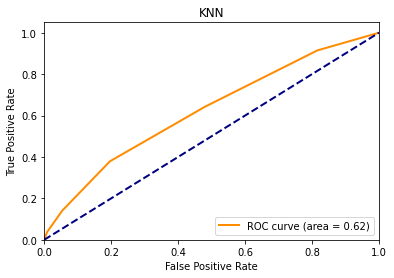

0.6237924927546847

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

B = 185
n_test = 50
y_score = np.zeros([n_test,B]) 
y_test_all = np.zeros([n_test,B]) 
for b in range(B): 
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=n_test)
    mk=np.mean(X_train,axis=0)
    sk=np.maximum(np.std(X_train,axis=0),10*np.finfo(float).eps)
    X_train, X_test = np.add(X_train,-mk), np.add(X_test,-mk)
    X_train, X_test = np.multiply(X_train,1/sk),np.multiply(X_test,1/sk)
    KNN = KNeighborsClassifier()  #n_estimators=20,max_depth=5
    KNN.fit(X_train, y_train)
    y_score[:,b] = KNN.predict_proba(X_test)[:,1]
    y_test_all[:,b] = y_test
              
ROC(y_test_all,y_score,"KNN")

train score: 0.7007299270072993
test score: 0.66


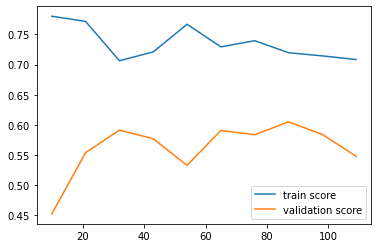

In [ ]:
print('train score:', KNN.score(X_train, y_train))
print('test score:', KNN.score(X_test, y_test))

evaluation(KNN, X_train, y_train)

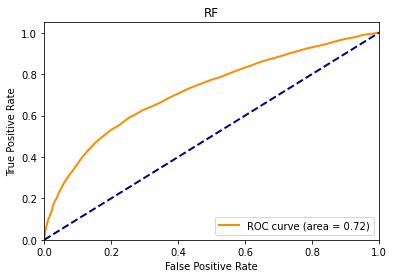

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# On constitue les jeux d'entrainement et de test avec le module sklearn 
# On normalise les données même si c'est pas nécessaire pour l'algorithme des randoms forest
# On teste notre modèle avec une validation croisée et une courbe ROC 

B = 185
n_test = 50
y_score = np.zeros([n_test,B]) 
y_test_all = np.zeros([n_test,B]) 
for b in range(B): 
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=n_test)
    mk=np.mean(X_train,axis=0)
    sk=np.maximum(np.std(X_train,axis=0),10*np.finfo(float).eps)
    X_train, X_test = np.add(X_train,-mk), np.add(X_test,-mk)
    X_train, X_test = np.multiply(X_train,1/sk),np.multiply(X_test,1/sk)
    RF = RandomForestClassifier()  #n_estimators=20,max_depth=5
    RF.fit(X_train,y_train)
    y_score[:,b] = RF.predict_proba(X_test)[:,1]
    y_test_all[:,b] = y_test
              
ROC(y_test_all,y_score,"RF")

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

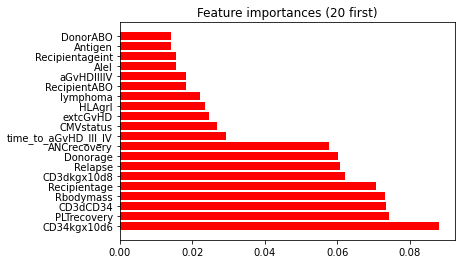

In [ ]:
# Plot the feature importances of the last forest
plt.figure(1)
plt.clf()
plt.title("Feature importances (20 first)")
plt.barh(range(20), importances[indices][:20],
       color="r", align="center")
plt.yticks(range(20), [X.columns[i] for i in indices[:20]])
plt.show()

train score: 1.0
test score: 0.76


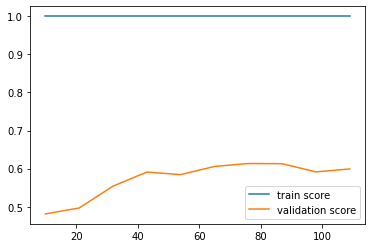

In [ ]:
print('train score:', RF.score(X_train, y_train))
print('test score:', RF.score(X_test, y_test))

evaluation(RF, X_train, y_train)

# On peut remarquer une tendance à l'overfeeting. 
# On pourra essayer différente méthodes pour y remédier comme par exemple la sélection de variable.  

### Sélection de variables 

Nous allons utiliser le modèle des random forest pour sélectionner les variables les plus importantes. Nous essairons différentes configurations (entre 10 et 15 variables). 

In [ ]:
importances = RF.feature_importances_
indices_boost = np.argsort(importances)[::-1]
best_features = X.columns[indices_boost][:12]

# Après avoir testé plusieurs valeurs, C'est en sélectionnant les 12 meilleures variables que l'on obtient les meilleures résulats
# On aurait pu automatiser la recherche avec une boucle ou en utilisant l'outil GridSearchCV de la librairie SKLearn
best_features

X_2 = X.loc[:,best_features]
X_2.shape

(187, 12)

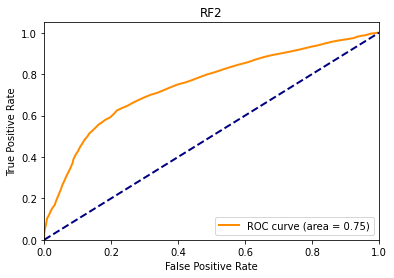

0.7477374693159169

In [ ]:
B = 185
n_test = 50
y_score = np.zeros([n_test,B]) 
y_test_all = np.zeros([n_test,B]) 
for b in range(B): 
    X_train, X_test, y_train, y_test = train_test_split(X_2,y,test_size=n_test)
    mk=np.mean(X_train,axis=0)
    sk=np.maximum(np.std(X_train,axis=0),10*np.finfo(float).eps)
    X_train, X_test = np.add(X_train,-mk), np.add(X_test,-mk)
    X_train, X_test = np.multiply(X_train,1/sk),np.multiply(X_test,1/sk)
    RF2 = RandomForestClassifier()  #n_estimators=20,max_depth=5
    RF2.fit(X_train,y_train)
    y_score[:,b] = RF2.predict_proba(X_test)[:,1]
    y_test_all[:,b] = y_test
              
ROC(y_test_all,y_score,"RF2")

train score: 1.0
test score: 0.72


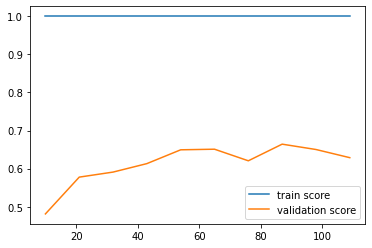

In [ ]:
print('train score:', RF2.score(X_train, y_train))
print('test score:', RF2.score(X_test, y_test))

evaluation(RF2, X_train, y_train)

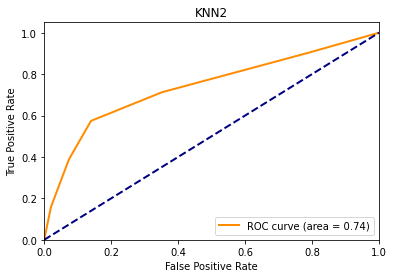

0.738392972459182

In [ ]:
B = 185
n_test = 50
y_score = np.zeros([n_test,B]) 
y_test_all = np.zeros([n_test,B]) 
for b in range(B): 
    X_train, X_test, y_train, y_test = train_test_split(X_2,y,test_size=n_test)
    mk=np.mean(X_train,axis=0)
    sk=np.maximum(np.std(X_train,axis=0),10*np.finfo(float).eps)
    X_train, X_test = np.add(X_train,-mk), np.add(X_test,-mk)
    X_train, X_test = np.multiply(X_train,1/sk),np.multiply(X_test,1/sk)
    KNN2 = KNeighborsClassifier()  #n_estimators=20,max_depth=5
    KNN2.fit(X_train, y_train)
    y_score[:,b] = KNN2.predict_proba(X_test)[:,1]
    y_test_all[:,b] = y_test
              
ROC(y_test_all,y_score,"KNN2")

train score: 0.8321167883211679
test score: 0.76


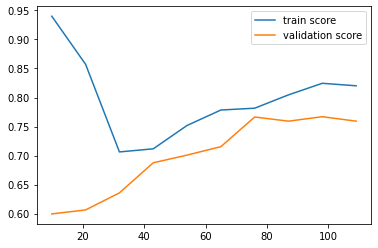

In [ ]:
print('train score:', KNN2.score(X_train, y_train))
print('test score:', KNN2.score(X_test, y_test))

evaluation(KNN2, X_train, y_train)

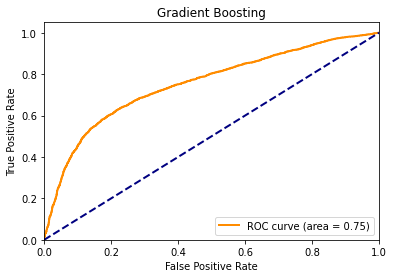

0.7526912369664266

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

B = 185
n_test = 50
y_score = np.zeros([n_test,B]) 
y_test_all = np.zeros([n_test,B]) 
for b in range(B): 
    X_train, X_test, y_train, y_test = train_test_split(X_2,y,test_size=n_test)
    mk=np.mean(X_train,axis=0)
    sk=np.maximum(np.std(X_train,axis=0),10*np.finfo(float).eps)
    X_train, X_test = np.add(X_train,-mk), np.add(X_test,-mk)
    X_train, X_test = np.multiply(X_train,1/sk),np.multiply(X_test,1/sk)
    GBC = GradientBoostingClassifier(loss='exponential',n_estimators=200,max_features=5)
    GBC.fit(X_train,y_train)
    y_score[:,b] = GBC.predict_proba(X_test)[:,1]
    y_test_all[:,b] = y_test
              
ROC(y_test_all,y_score,"Gradient Boosting")

train score: 1.0
test score: 0.76


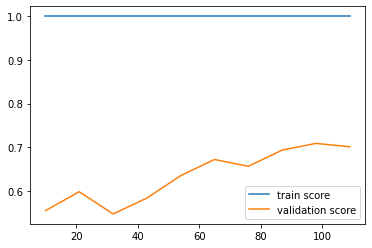

In [ ]:
print('train score:', GBC.score(X_train, y_train))
print('test score:', GBC.score(X_test, y_test))

evaluation(GBC, X_train, y_train)

## Résultats 

De manière générale on obtient bien de meilleurs résultats en procédant à une séléction de variable. Les modèles semblent se valoir dans l'ensemble même si les modèles KNN et Gradient boosting semblent être légèrement plus performant. 

In [ ]:
print('train score avec sélection de variable : ', KNN2.score(X_train, y_train))
print('test score avec sélection de variable : ', KNN2.score(X_test, y_test))

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=n_test)
mk=np.mean(X_train,axis=0)
sk=np.maximum(np.std(X_train,axis=0),10*np.finfo(float).eps)
X_train, X_test = np.add(X_train,-mk), np.add(X_test,-mk)
X_train, X_test = np.multiply(X_train,1/sk),np.multiply(X_test,1/sk)

print('train score sans sélection de variable :', KNN.score(X_train, y_train))
print('test score sans sélection de variable :', KNN.score(X_test, y_test))



train score avec sélection de variable :  0.8029197080291971
test score avec sélection de variable :  0.8
train score sans sélection de variable : 0.7007299270072993
test score sans sélection de variable : 0.68


In [ ]:
#  Voir la théorie sur les courbes ROC 
#  Comprendre comment elle fait sa cross validation 

#  Comparer les méthodes de cross validation pour voir laquelle on choisit 

#  Rajouter la partie modèle de COX 

#  Conclure 

# Régression de Cox et courbes de Kapplan Meier 

Pour en revenir aux articles associées au dataset. L'objectif des études était d'identifier les facteurs les plus importants influençant le succès ou l'échec de la procédure de transplantation. En particulier, l'objectif était de vérifier l'hypothèse selon laquelle l'augmentation du dosage de cellules CD34+/kg prolonge la durée de survie globale sans apparition simultanée d'événements indésirables affectant la qualité de vie des patients.

Les seuils de dose cellulaire CD34+ ont été choisis en prenant 2 cohortes d'enfants à peu près similaires. 
Pour éviter un éventuel biais en faveur de doses de cellules CD34+ plus élevées chez les patients plus jeunes, ils ont analysé séparément les tranches d'âge 0-10 ans et 10-20 ans.
Les médianes ont donc étaient ajusté en fonction de l'âge.

In [ ]:
data_test = data_full.loc[:,['Recipientage', 'CD34kgx10d6', 'survival_time', 'survival_status']]
data_test

# On sépare notre dataset en fonction de l'age des patients avec une limite à 10 ans 
data_minor = data_test[data_test['Recipientage']< 10 ]
data_major = data_test[data_test['Recipientage']>= 10]

# Pour chaque groupe de patient on les réparti de nouveau en sous groupe en fonction de la valeur médiane de cellule CD34+ des groupes
data_min_cd34inf = data_minor[data_minor['CD34kgx10d6'] < 12.13]
data_min_cd34sup = data_minor[data_minor['CD34kgx10d6'] >= 12.13]

data_maj_cd34inf = data_major[data_major['CD34kgx10d6'] < 7.2]
data_maj_cd34sup = data_major[data_major['CD34kgx10d6'] >= 7.2]

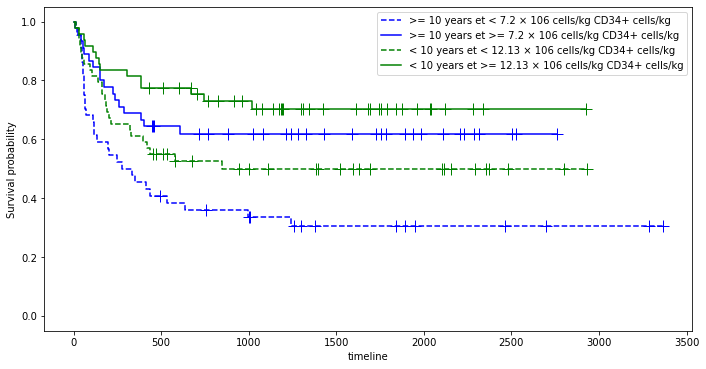

In [ ]:
from lifelines import KaplanMeierFitter


kmf = KaplanMeierFitter()



fig = plt.figure(figsize=(12, 6))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])

kmf.fit(data_maj_cd34inf['survival_time'], data_maj_cd34inf['survival_status'])
kmf.plot(ax=ax, ci_show=False, show_censors=True, label='>= 10 years et < 7.2 × 106 cells/kg CD34+ cells/kg', c= 'blue', ls ='--')

kmf.fit(data_maj_cd34sup['survival_time'], data_maj_cd34sup['survival_status'])
kmf.plot(ax=ax, ci_show=False, show_censors=True, label='>= 10 years et >= 7.2 × 106 cells/kg CD34+ cells/kg', c= 'blue')

ax.set_ylabel('Survival probability')
ax.set_xlabel('Time in day')
ax.set_ylim([-0.05, 1.05])


kmf.fit(data_min_cd34inf['survival_time'], data_min_cd34inf['survival_status'])
kmf.plot(ax=ax, ci_show=False, show_censors=True, label='< 10 years et < 12.13 × 106 cells/kg CD34+ cells/kg', c="green", ls ='--')

kmf.fit(data_min_cd34sup['survival_time'], data_min_cd34sup['survival_status'])
kmf.plot(ax=ax, ci_show=False, show_censors=True, label='< 10 years et >= 12.13 × 106 cells/kg CD34+ cells/kg', c="green")

plt.show()

# Visuellement on observe bien une différence dans les courbes de survie pour 2 sous groupes d'un même groupe 
# Pour confirmer ce qu'on voit visuellement, on va confirmer cette différence à l'aide d'un test log-rank 

In [ ]:
from lifelines.statistics import logrank_test

T1, E1 = data_maj_cd34inf['survival_time'], data_maj_cd34inf['survival_status']
T2, E2 = data_maj_cd34sup['survival_time'], data_maj_cd34sup['survival_status']

results = logrank_test(T1, T2, event_observed_A=E1, event_observed_B=E2)

# results.print_summary()
print(results.p_value)        
print(results.test_statistic) 

T_1, E_1 = data_min_cd34inf['survival_time'], data_min_cd34inf['survival_status']
T_2, E_2 = data_min_cd34sup['survival_time'], data_min_cd34sup['survival_status']

results = logrank_test(T_1, T_2, event_observed_A=E_1, event_observed_B=E_2)

print(results.p_value)        
print(results.test_statistic) 

# Nous avons une confirmation par le test logrank que les deux courbes de survie sont bien significativement différente
# Par conséquent la concentration en cellule CD34+ a bien un impacte sur les courbes de survies chez patients greffés

0.004866116193112413
7.928535684367093
0.031810959726850094
4.608655774245017


In [ ]:
from lifelines import CoxPHFitter
cph = CoxPHFitter(penalizer=0.1)

cph.fit(data_full, 'survival_time', 'survival_status')

print(cph.summary.p[cph.summary.p < 0.05] )
print(cph.hazard_ratios_[cph.summary.p < 0.05])

covariate
RecipientRh    2.553335e-02
Relapse        9.214176e-04
ANCrecovery    2.005612e-04
PLTrecovery    6.045191e-09
Name: p, dtype: float64
covariate
RecipientRh    2.061843
Relapse        2.507103
ANCrecovery    1.000003
PLTrecovery    1.000002
Name: exp(coef), dtype: float64


Le modèle de Cox, appellé aussi régression de Cox est un modèle d’apprentissage très utilisé en analyse de survie. 
Il permet d’évaluer l’influence de différentes variables sur la durée de survie des patients.
Une fois que le modèle est entrainé il va être capable de faire des prédictions sur les courbes de survie de nouveaux patients.

Nous avons entrainer le modèle avec l'ensemble des variables du dataset. 
Parmi les 4 variables identifiées comme significative par le modèle 3 de ces variables étaient aussi identifié comme variable très importante par le modèle des random forest (Relapse, ANCrecovery, PLTrecovery). De plus la variable RecipientRh à la p-value la plus proche du seuil de significativité. 

Si on prend l'exemple de PLTrecovery qui est le temps de récupération plaquettaire : le risque de décès augmente d'un facteur 1.000002 pour chaque unité de temps supplémentaire  

In [ ]:
# On test avec les donénes concernant les celulles CD34+ seul pour voir ce que le modèle retourne

data_CD34 = data_full.loc[:,['CD34kgx10d6', 'survival_time', 'survival_status']]
cox = CoxPHFitter()
cox.fit(data_CD34, 'survival_time', 'survival_status')

print(cox.summary.p)
print(cox.hazard_ratios_)

# Avec la variable seule le modèle la considère bien comme significative et on voit que le hazard ration est inférieur à 1 
# Donc le taux de cellule CD34+ a bien une tendance à faire diminuer le risque de décès chez les patients greffés.

covariate
CD34kgx10d6    0.034754
Name: p, dtype: float64
covariate
CD34kgx10d6    0.971336
Name: exp(coef), dtype: float64


## Conclusion 
 - Nous avons construit différents modèles de classification sur notre dataset et nous avons obtenu des score relativement performant sur nos jeux de test (jusqu'à 80% de précision avec le meilleur des modèles) 
 - Grace à la sélection de variables on a réussi limiter l'overfeeting sur certains modèles et augmenter les performances des modèles sur les jeux de test 
 - Nous avons pu reproduire les résultats des différents articles en visualisant les courbes de survie et en confirmant nos observation avec un test statistique. L'entrainement du modèle de Cox a permis de retrouver les variables importantes (précédemment identifiées) pour prédire les probabilité de survie et quantifier l'influence sur les facteurs de risque.
 